In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

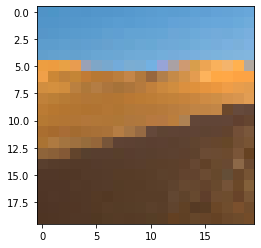

In [101]:
img = Image.fromarray(np.asarray(Image.open('desert.jpg'))[250:750,150:600])
img = img.resize((20,20), resample = Image.NEAREST)
img = np.asarray(img)
#img = img[5:25,5:25,...]
plt.imshow(img, vmin=0, vmax=255)

In [138]:
import scipy
dim = img.shape[0] * img.shape[1]
weights = np.zeros((dim, dim))
weights.shape

(400, 400)

In [139]:
DIST_PARAM = 10
sigma_squared_i = 100
sigma_squared_x = 50

for i in range(weights.shape[0]):
    i_row, i_col = i // img.shape[0], i % img.shape[1]
    for row_offset in range(-min(DIST_PARAM, i_row), min(DIST_PARAM + 1, img.shape[0] - i_row)):
        j_row = i_row + row_offset
        for col_offset in range(-min(DIST_PARAM, i_col), min(DIST_PARAM + 1, img.shape[1] - i_col)):
            j_col = i_col + col_offset
            dist = abs(row_offset) + abs(col_offset)
            if dist > 2*DIST_PARAM:
                print("ERROR")
                print(dist)
            j = j_row * img.shape[1] + j_col
            intensity_exp = (np.linalg.norm(np.array(img[j_row, j_col] - img[i_row, i_col]))**2)/sigma_squared_i
            distance_exp = dist**2/sigma_squared_x
            weights[i,j] = np.exp(-intensity_exp - distance_exp)

In [104]:
weights.shape

(400, 400)

In [105]:
import cvxpy as cvx

X = cvx.Variable((dim, dim), PSD=True)
obj = cvx.trace(weights @ X)
constr = [cvx.diag(X) == 1, cvx.sum(X) <= 0.15*dim*dim]
problem = cvx.Problem(cvx.Maximize(obj), constraints=constr)
problem.solve(solver=cvx.SCS, verbose=True, max_iters = 2500)

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Dec 11 08:35:30 PM: Your problem has 160000 variables, 2 constraints, and 0 parameters.
(CVXPY) Dec 11 08:35:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 11 08:35:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 11 08:35:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 11 08:35:30 PM: Compiling problem (target solver=SCS).
(CVXPY) Dec 11 08:35:30 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> C

2677.9146993054655

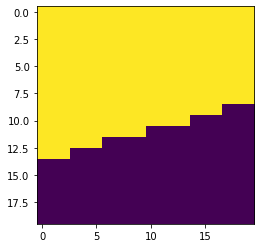

In [116]:
import math

# recover the original vectors
sol = X.value
S, eig, S_T = np.linalg.svd(X.value)
V = np.transpose(S * np.sqrt(eig))  

# do the random hyperplane rounding
random_hyperplane_rounding = np.random.randn(dim)
# rearrange the cut to form an image again
cut = np.sign(random_hyperplane_rounding @ V).reshape(int(math.sqrt(dim)), int(math.sqrt(dim)), order = 'C')
#display the image
plt.imshow((cut+1)*125)

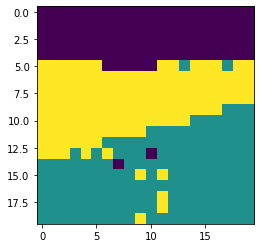

In [124]:
num_cuts = 3
max_dot_product_rounding = np.random.randn(num_cuts, dim)
angles = np.abs(max_dot_product_rounding @ V)
partitions = np.argmax(angles, axis = 0).reshape(int(math.sqrt(dim)), int(math.sqrt(dim)), order = 'C')
plt.imshow(partitions*125)

In [140]:
weights = np.array(weights)
def select_random_edge(weights):
    weights_prob = weights/np.sum(weights)
    val = np.random.choice(weights.flatten(), p = weights_prob.flatten())
    result = np.where(weights == val)
    ls = list(zip(result[0], result[1]))
    coord = ls[np.random.randint(len(ls))]
    return coord

def contract_edge(weights, p1, p2):
    
    new_weights = weights
    
    if p1 == p2:
        print("ERROR")
        return weights
    
    #shift weight
    for i in range(len(weights)):
        #move weight ending at p2
        new_weights[i][p1] += weights[i][p2]
        new_weights[i][p2] = 0

        #move weight starting at p2
        new_weights[p1][i] += weights[p2][i]
        new_weights[p2][i] = 0
    
    #weights = np.delete(weights, p2, axis=0)
    #weights = np.delete(weights, p2, axis=1)
    
    #remove self loops
    for i in range(len(weights)):
        new_weights[i][i] = 0
    
    return new_weights
    

print(np.sum(weights))
k = 2
vertices = len(weights)
groups = np.arange(0,len(weights),1)

num_steps = 0

while num_steps < vertices - k:
    i, j = select_random_edge(weights)
    groups[j] = i
    weights = contract_edge(weights, i, j)
    num_steps += 1

print(np.sum(weights))

2677.8829600855292
1.9581802075495664e-98


In [142]:
def set_to_groups(groups):
    groups_temp = np.zeros(len(groups))
    for i in range(len(groups)):
        ind = i
        val = groups[ind]
        while ind != val:
            ind = val
            val = groups[ind]
        groups_temp[i] = val
    return groups_temp

res = set_to_groups(groups)
print(res)

for i in range(len(groups)):
    if i == groups[i]:
        print(i)

[106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106.
 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106.
 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106.
 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106.
 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106.
 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106.
 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106.
 106. 106. 376. 376. 376. 376. 376. 106. 106. 106. 106. 106. 106. 106.
 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376.
 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376.
 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376.
 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376.
 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376.
 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376. 376.
 376. 